## set up environment

Set up new virtual environment by telling `venv` (a python module) to create a new environment at `./venv`
```bash
python -m venv venv
```
Redirect current bash instance to look inside of `venv` for `python` related stuff before checking the system `python` paths.

```bash
source venv/bin/activate
```

Install dependencies
```bash
pip install ipython jupyter numpy scipy torch matplotlib seaborn
```

Read in an image

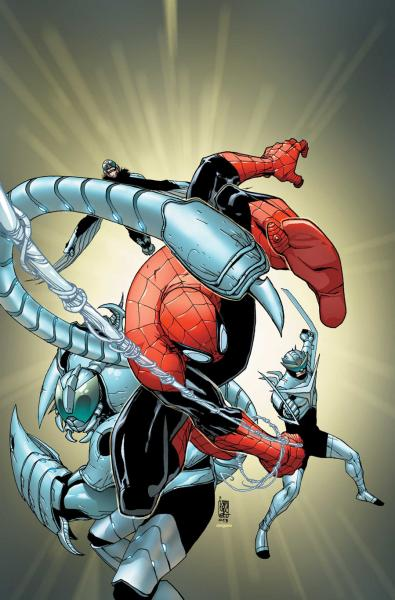

In [1]:
from PIL import Image
image = Image.open("data/spidey.jpg")
image

Convert image to numpy array

In [4]:
import numpy as np
img_mat = np.asarray(image)
type(img_mat)

MAX_PIXEL_VAL = 255.
img_mat = img_mat / MAX_PIXEL_VAL
print(f"image is {img_mat.shape[0]} x {img_mat.shape[1]} with channel order {image.mode}")
#print(img_mat)

image is 600 x 395 with channel order RGB
[[[0.31372549 0.34117647 0.31372549]
  [0.30980392 0.3372549  0.30980392]
  [0.30980392 0.3372549  0.30980392]
  ...
  [0.21176471 0.25882353 0.25882353]
  [0.21176471 0.25882353 0.25882353]
  [0.21176471 0.25882353 0.25882353]]

 [[0.31372549 0.34117647 0.31372549]
  [0.31372549 0.34117647 0.31372549]
  [0.30980392 0.3372549  0.30980392]
  ...
  [0.21176471 0.25882353 0.25882353]
  [0.21176471 0.25882353 0.25882353]
  [0.21176471 0.25882353 0.25882353]]

 [[0.31372549 0.34117647 0.31372549]
  [0.31372549 0.34117647 0.31372549]
  [0.31372549 0.34117647 0.31372549]
  ...
  [0.21176471 0.25882353 0.25882353]
  [0.21176471 0.25882353 0.25882353]
  [0.21176471 0.25882353 0.25882353]]

 ...

 [[0.22745098 0.27058824 0.27843137]
  [0.22745098 0.27058824 0.27843137]
  [0.22745098 0.2745098  0.2745098 ]
  ...
  [0.29019608 0.3254902  0.30588235]
  [0.29019608 0.3254902  0.30588235]
  [0.29019608 0.32941176 0.29803922]]

 [[0.22745098 0.27058824 0.27843

Barebones user class with a "unique?" user ID

In [185]:
import secrets
from functools import reduce
from operator import concat

class User(object):
    """barebones user"""
    def __init__(self, **metadata):    
        self.metadata = metadata
        self.__userid = int(sum(
                                map(ord, 
                                     reduce(concat,
                                            map(str, metadata.values())))))
        
    def __getitem__(self, key):
        return self.metadata.__getitem__(key)
    
    def __setitem__(self, key, value):
        return self.metadata.__setitem(key, value)
    
    @property
    def userid(self):
        return self.__userid
    
    def __str__(self):
        return f"{self.__class__.__name__}({self.metadata})"
    
    def __repr__(self):
        return str(self)

Applying and generating a user signature

In [186]:
from typing import Tuple

def generate_mask(mask_size, img_height, img_width, seed=None):
    # generating a mask -- it's just a `mask_size` many coordinates 
    # that live on an `img_height` x `img_width` grid
    if seed is not None:
        np.random.seed(seed)
        
    left  = np.random.randint(low=0, high=img_height, size=mask_size)
    right = np.random.randint(low=0, high=img_width, size=mask_size)
    return left, right

def apply_signature(img: np.ndarray, fillvalue=1., mask_size=5, seed=None):
    # gathering the mask information
    height, width = img.shape[:2]
    mask_fst, mask_snd = generate_mask(mask_size, 
                                       height, width, seed=seed)
    
    # applying the mask
    img[mask_fst, mask_snd, :] = fillvalue
    return img, (mask_fst, mask_snd)


def apply_signature_given_user(img, user):
    seed = user.userid
    signed, mask_info = apply_signature(img, mask_size=5, seed=seed)
    
    return signed, mask_info

### Condition signage on userid

In [197]:
me = User(name='samus', lastname='aran')
you = User(name='mario', lastname='luigi')
badguy = User(name="blackbeard", lastname='yarr')

userdb = [me, you, badguy]
print([(user['name'], user.userid) for user in userdb])

signed, maskinfo = apply_signature_given_user(img_mat, badguy)

[('samus', 971), ('mario', 1074), ('blackbeard', 1465)]


Render signed image

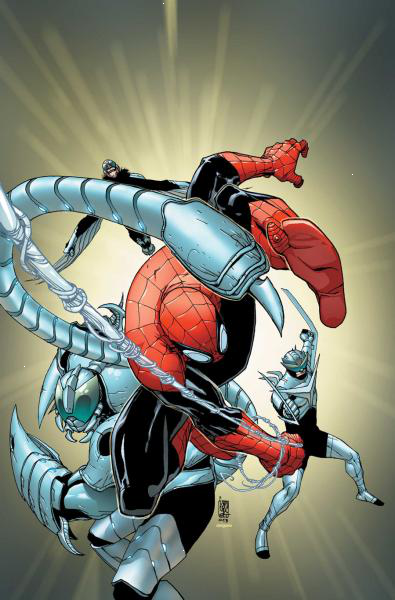

In [198]:
signed_image = Image.fromarray( (signed * 255).astype(np.uint8) )
signed_image

Recover user from signature

In [204]:
def recover_user_from_signature(img: np.ndarray, users, mask_size=5, fillvalue=1.):
    h, w, _ = img.shape
    for user in users:
        mask_info = generate_mask(mask_size, h, w, seed=user.userid)
        vals = img[mask_info[0], mask_info[1], :].ravel()
        if (vals == fillvalue).all():
            return user
    return None

In [205]:
pirate = recover_user_from_signature(signed, userdb)

In [207]:
pirate is badguy

True